In [1]:
! py -3.12 -m pip install split-folders



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import splitfolders

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


### Create Diseases Dataset

In [2]:
plantPathOfSource = "E:\\MS_USD\\Course 8_AAI-521_ComputerVision\\Final Project\\AAI-521-Group2_Project\\diseases"
destinationFolder = "E:\\MS_USD\\Course 8_AAI-521_ComputerVision\\Final Project\\AAI-521-Group2_Project\\DatasetForDiseasePrediction\\RawImages_WithClasses"

In [ ]:
plantFolders = os.listdir(plantPathOfSource)
for plant in plantFolders:
    try:
        diseasePathOfSource = plantPathOfSource + "\\" + plant
        diseaseFolder  = os.listdir(diseasePathOfSource)

        for disease in diseaseFolder:
            try:
                destPath = destinationFolder + "\\" + disease
                sourcePath = diseasePathOfSource + "\\" + disease
                if(not os.path.exists(destPath)):
                    # print(destPath)
                    shutil.copytree(sourcePath, destPath)
                else:
                    for file in os.listdir(sourcePath):
                        fileName = sourcePath +"\\" + file
                        destPath_copy = destPath + "\\" + file
                        shutil.copy2(fileName, destPath_copy)
                    print(disease)
            except Exception as ex:
                print("Exception", ex)
    except Exception as ex:
        print("Exception", ex)

### Split Disease Daset into Train and Test

In [3]:
splitDest = "E:\\MS_USD\\Course 8_AAI-521_ComputerVision\\Final Project\\AAI-521-Group2_Project\\DatasetForDiseasePrediction\\ImagesSplitIntoTrain_Test"
splitSource = "E:\\MS_USD\\Course 8_AAI-521_ComputerVision\\Final Project\\AAI-521-Group2_Project\\DatasetForDiseasePrediction\\RawImages_WithClasses"


In [ ]:
splitfolders.ratio(splitSource, output=splitDest, seed=42, ratio=(.8, .2))

### Removing Corrupted Images

In [ ]:
from PIL import Image

def remove_corrupted_images(folder_path):
    removed_files = []
    count = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg") or file.lower().endswith(".jpeg"):
                file_path = os.path.join(root, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                    img_bytes = tf.io.read_file(file_path)
                    _ = tf.image.decode_jpeg(img_bytes, channels=3)
                except Exception as e:
                    print(f"Removing corrupted file: {file_path} ({e})")
                    os.remove(file_path)
                    removed_files.append(file_path)
                    count+=1
    return removed_files, count

# Example usage
dataset_path = [splitDest + "\\" + "train", splitDest + "\\" + "val"]
for i in dataset_path:
    bad_files, count = remove_corrupted_images(i)
    print(f"Removed {len(bad_files)} corrupted images in {i}.")
    print(count)


Removing corrupted file: E:\MS_USD\Course 8_AAI-521_ComputerVision\Final Project\AAI-521-Group2_Project\DatasetForDiseasePrediction\ImagesSplitIntoTrain_Test\train\leaf blight\leaf blight386_.jpg ({{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeJpeg])
Removing corrupted file: E:\MS_USD\Course 8_AAI-521_ComputerVision\Final Project\AAI-521-Group2_Project\DatasetForDiseasePrediction\ImagesSplitIntoTrain_Test\train\leaf blight\leaf blight470_.jpg ({{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} jpeg::Uncompress failed. Invalid JPEG data or crop window. [Op:DecodeJpeg])
Removing corrupted file: E:\MS_USD\Course 8_AAI-521_ComputerVision\Final Project\AAI-521-Group2_Project\DatasetForDiseasePrediction\ImagesSplitIntoTrain_Test\train\leaf blight\leaf blight813_.jpg ({{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/tas

### MobileNetV2 Transfer Learning Model

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [10]:
batch_size = 32
img_height = 120
img_width = 120

train_ds = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 15142 files belonging to 14 classes.
Using 12114 files for training.
Found 15142 files belonging to 14 classes.
Using 3028 files for validation.


In [12]:
base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_height,img_width,3),
        include_top=False,
        weights="imagenet"  # Set to 'imagenet' if you want transfer learning
)
input = tf.keras.Input(shape=(img_height,img_width,3))
x = data_augmentation(input)
x = base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(14, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input, outputs=outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\Dell\AppData\Local\Temp\ipykernel_6816\2498582515.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # what to monitor
    patience=5,              # epochs with no improvement before stopping
    restore_best_weights=True # roll back to best weights
)

In [14]:
history_mobileNet = model.fit(train_ds, validation_data=val_ds,batch_size=32,epochs=20, callbacks=[early_stop])

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 628s 2s/step - accuracy: 0.5686 - loss: 1.2911 - val_accuracy: 0.3332 - val_loss: 4.7627
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.7485 - loss: 0.7155 - val_accuracy: 0.3233 - val_loss: 6.1677
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.7700 - loss: 0.6491 - val_accuracy: 0.4534 - val_loss: 3.8109
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.7892 - loss: 0.5946 - val_accuracy: 0.5449 - val_loss: 2.6452
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.7916 - loss: 0.5626 - val_accuracy: 0.5320 - val_loss: 2.3202
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.8042 - loss: 0.5429 - val_accuracy: 0.4875 - val_loss: 3.1597
Epoch 7/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - accuracy: 0.8173 - loss: 0.5114 - val_accuracy: 0.6443 - val_loss: 1.9704
Epoch 8/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.8149 - loss: 0.5216 - val_accu

In [18]:
model.save("..\\models\model_mobileNet_20Epochs.h5")

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Dell\AppData\Local\Temp\ipykernel_6816\51114671.py:1: SyntaxWarning: invalid escape sequence '\m'
  model.save("..\\models\model_mobileNet_20Epochs.h5")


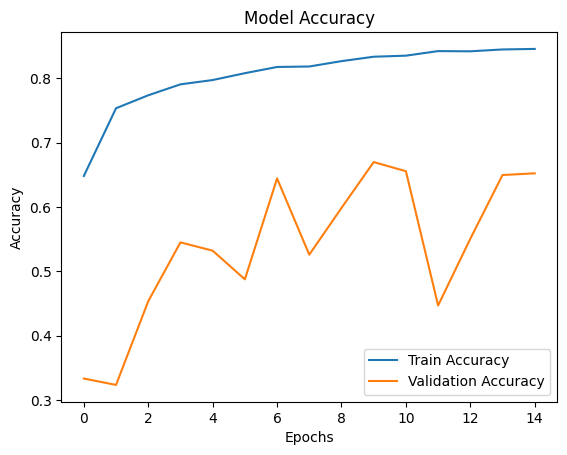

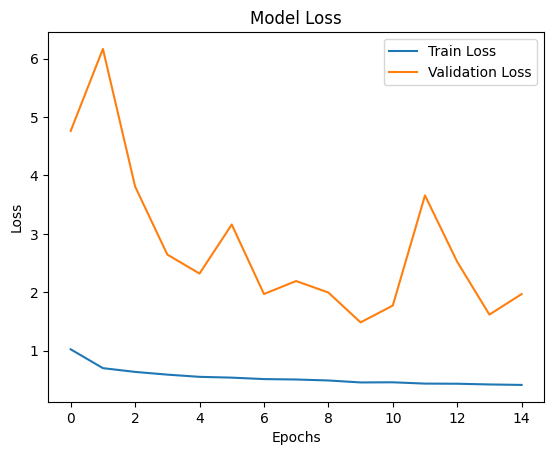

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(history_mobileNet.history['accuracy'], label="Train Accuracy")
plt.plot(history_mobileNet.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()
plt.tight_layout()

plt.plot(history_mobileNet.history['loss'], label="Train Loss")
plt.plot(history_mobileNet.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()
plt.tight_layout()

In [25]:
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy:", val_acc*100)

95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - accuracy: 0.6719 - loss: 1.4901
Validation accuracy: 66.97490215301514


In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "val",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3795 files belonging to 14 classes.
Using 759 files for validation.


In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc*100)

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.6689 - loss: 1.3452
Test accuracy: 66.40316247940063


### Fine Tuning MobileNetV2

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds_tuned = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "train",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds_tuned = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

Found 15142 files belonging to 14 classes.
Using 12114 files for training.
Found 15142 files belonging to 14 classes.
Using 3028 files for validation.


In [37]:
base_model_tuned = tf.keras.applications.MobileNetV2(
        input_shape=(img_height,img_width,3),
        include_top=False,
        weights="imagenet"  # Set to 'imagenet' if you want transfer learning
)
input = tf.keras.Input(shape=(img_height,img_width,3))
x = data_augmentation(input)
x = base_model_tuned(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(14, activation='softmax')(x)

model_tuned = tf.keras.models.Model(inputs=input, outputs=outputs)

model_tuned.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [38]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # what to monitor
    patience=5,              # epochs with no improvement before stopping
    restore_best_weights=True # roll back to best weights
)

In [39]:
history_mobileNet_tuning = model_tuned.fit(train_ds_tuned, validation_data=train_ds_tuned,batch_size=32,epochs=20, callbacks=[early_stop])

Epoch 1/20


Copying files: 92 files [3:40:17, 143.67s/ files]


379/379 ━━━━━━━━━━━━━━━━━━━━ 2505s 6s/step - accuracy: 0.5518 - loss: 1.3829 - val_accuracy: 0.5202 - val_loss: 1.6612
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2333s 6s/step - accuracy: 0.7984 - loss: 0.5447 - val_accuracy: 0.7440 - val_loss: 0.8143
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2442s 6s/step - accuracy: 0.8400 - loss: 0.4395 - val_accuracy: 0.8222 - val_loss: 0.5016
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2457s 6s/step - accuracy: 0.8554 - loss: 0.4010 - val_accuracy: 0.8601 - val_loss: 0.3680
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2396s 6s/step - accuracy: 0.8600 - loss: 0.3717 - val_accuracy: 0.8446 - val_loss: 0.4240
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2371s 6s/step - accuracy: 0.8744 - loss: 0.3378 - val_accuracy: 0.8645 - val_loss: 0.3619
Epoch 7/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2407s 6s/step - accuracy: 0.8788 - loss: 0.3179 - val_accuracy: 0.8997 - val_loss: 0.2624
Epoch 8/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 2347s 6s/step - accuracy: 0.8991 - loss: 0.2886 - val_accurac

In [40]:
model_tuned.save("..\\models\model_mobileNet_20Epochs_finetuned.h5")

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Dell\AppData\Local\Temp\ipykernel_6816\640557468.py:1: SyntaxWarning: invalid escape sequence '\m'
  model_tuned.save("..\\models\model_mobileNet_20Epochs_finetuned.h5")


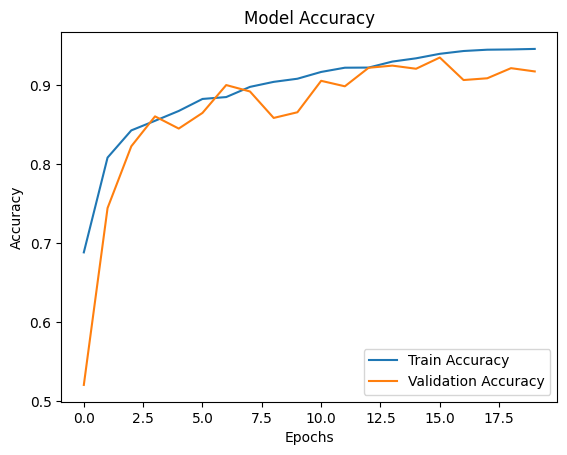

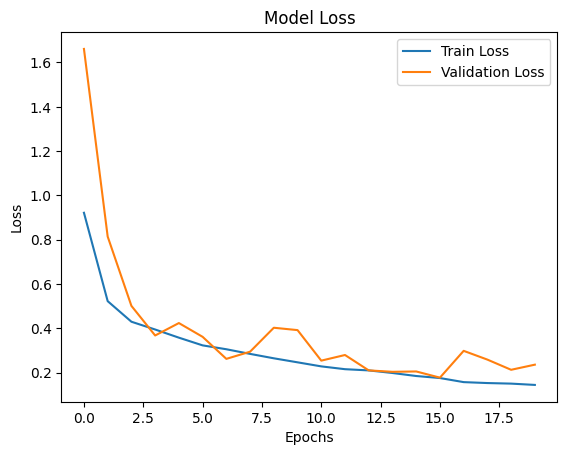

<Figure size 640x480 with 0 Axes>

In [41]:
plt.plot(history_mobileNet_tuning.history['accuracy'], label="Train Accuracy")
plt.plot(history_mobileNet_tuning.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()
plt.tight_layout()

plt.plot(history_mobileNet_tuning.history['loss'], label="Train Loss")
plt.plot(history_mobileNet_tuning.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()
plt.tight_layout()

In [7]:
test_ds_tuned = tf.keras.utils.image_dataset_from_directory(
    splitDest + "\\" + "val",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3795 files belonging to 14 classes.
Using 759 files for validation.


In [8]:
model_tuned = tf.keras.models.load_model("..\\models\model_mobileNet_20Epochs_finetuned.h5")

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Dell\AppData\Local\Temp\ipykernel_18580\674737320.py:1: SyntaxWarning: invalid escape sequence '\m'
  model_tuned = tf.keras.models.load_model("..\\models\model_mobileNet_20Epochs_finetuned.h5")


In [9]:
val_loss, val_acc = model_tuned.evaluate(val_ds_tuned)
print("Validation accuracy:", val_acc*100)

95/95 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8696 - loss: 0.4183
Validation accuracy: 87.94583678245544


In [10]:
test_loss, test_acc = model_tuned.evaluate(test_ds_tuned)
print("Test accuracy:", test_acc*100)

24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 983ms/step - accuracy: 0.8992 - loss: 0.3340
Test accuracy: 89.5915687084198


### MobileNetV2
<b>Parameters:</b>
<li>Epochs : 20</li>
<li>Optimizer : Adam</li>
<li>Batch Size : 32</li>
<li>Image Size : (120,120,3)</li>
<b>Train Accuracy</b> : 84 % <br>
<b>Validation Accuracy</b> : 66.9 %<br>
<b>Test Accuracy</b> : 66.4 %<br>

### MobileNetV2 After fine tuning Parameters

<b>Parameters:</b>
<li>Epochs : 20</li>
<li>Optimizer : Adam with learniing rate (0.0001)</li>
<li>Batch Size : 32</li>
<li>Image Size : (224,224,3)</li>
<b>Train Accuracy</b> : 96 %<br>
<b>Validation Accuracy</b> : 87.94 %<br>
<b>Test Accuracy</b> : 89.57 %<br>